In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [4]:
data = torch.from_numpy(df.values).float()
data

tensor([[1.7990e+01, 1.0380e+01, 1.2280e+02,  ..., 4.6010e-01, 1.1890e-01,
         0.0000e+00],
        [2.0570e+01, 1.7770e+01, 1.3290e+02,  ..., 2.7500e-01, 8.9020e-02,
         0.0000e+00],
        [1.9690e+01, 2.1250e+01, 1.3000e+02,  ..., 3.6130e-01, 8.7580e-02,
         0.0000e+00],
        ...,
        [1.6600e+01, 2.8080e+01, 1.0830e+02,  ..., 2.2180e-01, 7.8200e-02,
         0.0000e+00],
        [2.0600e+01, 2.9330e+01, 1.4010e+02,  ..., 4.0870e-01, 1.2400e-01,
         0.0000e+00],
        [7.7600e+00, 2.4540e+01, 4.7920e+01,  ..., 2.8710e-01, 7.0390e-02,
         1.0000e+00]])

In [5]:
x = data[:, :10]
y = data[:, -1:]
print(x.size(), y.size())

torch.Size([569, 10]) torch.Size([569, 1])


In [6]:
indices = torch.randperm(x.size(0))
len(indices)

569

In [7]:
ratio = [.6, .2, .2]
train_cnt = int(x.size(0) * ratio[0])
valid_cnt = int(x.size(0) * ratio[1])
test_cnt = x.size(0) - train_cnt - valid_cnt

print(f'Train_cnt : {train_cnt} / Valid_cnt : {valid_cnt} / Test_cnt : {test_cnt}')

Train_cnt : 341 / Valid_cnt : 113 / Test_cnt : 115


In [8]:
x = torch.index_select(x, dim=0, index=indices).split([train_cnt, valid_cnt, test_cnt], dim=0)
y = torch.index_select(y, dim=0, index=indices).split([train_cnt, valid_cnt, test_cnt],dim=0)

for x_n, y_n in zip(x, y):
    print(x_n.size(), y_n.size())

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


In [9]:
class Custom_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        super().__init__()
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [10]:
batch_size = 128
early_stop = 100
n_epoch = 10000
print_interval = 500

In [11]:
train_loader = DataLoader(dataset = Custom_Dataset(x[0], y[0]),
                          batch_size = batch_size,
                          shuffle = True
                         )

valid_loader = DataLoader(dataset = Custom_Dataset(x[1], y[1]),
                          batch_size = batch_size,
                          shuffle = False
                         )

test_loader = DataLoader(dataset = Custom_Dataset(x[2], y[2]),
                          batch_size = batch_size,
                          shuffle = False
                         )

In [12]:
print(len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset))

341 113 115


In [16]:
class My_model(nn.Module):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__()
        
        self.linear1 = nn.Linear(input_dim, 9)
        self.linear2 = nn.Linear(9, 8)
        self.linear3 = nn.Linear(8, 7)
        self.linear4 = nn.Linear(7, 6)
        self.linear5 = nn.Linear(6, 5)
        self.linear6 = nn.Linear(5, 4)
        self.linear7 = nn.Linear(4, 3)
        self.linear8 = nn.Linear(3, 2)
        self.linear9 = nn.Linear(2, output_dim)
        self.act1 = nn.LeakyReLU()
        self.act2 = nn.Sigmoid()
        
    def forward(self, x):
        h = self.act1(self.linear1(x))
        h = self.act1(self.linear2(h))
        h = self.act1(self.linear3(h))
        h = self.act1(self.linear4(h))
        h = self.act1(self.linear5(h))
        h = self.act1(self.linear6(h))
        h = self.act1(self.linear7(h))
        h = self.act1(self.linear8(h))
        h = self.linear9(h)
        h = self.act2(h)
        return h
        
        
model = My_model(x[0].size(-1), y[0].size(-1))
model

My_model(
  (linear1): Linear(in_features=10, out_features=9, bias=True)
  (linear2): Linear(in_features=9, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=7, bias=True)
  (linear4): Linear(in_features=7, out_features=6, bias=True)
  (linear5): Linear(in_features=6, out_features=5, bias=True)
  (linear6): Linear(in_features=5, out_features=4, bias=True)
  (linear7): Linear(in_features=4, out_features=3, bias=True)
  (linear8): Linear(in_features=3, out_features=2, bias=True)
  (linear9): Linear(in_features=2, out_features=1, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (act2): Sigmoid()
)

In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
for xx, yy in train_loader:
    print(xx.size(), yy.size())

torch.Size([128, 10]) torch.Size([128, 1])
torch.Size([128, 10]) torch.Size([128, 1])
torch.Size([85, 10]) torch.Size([85, 1])


In [19]:
lowest_loss = np.inf
lowest_epoch = np.inf
best_model = None

In [21]:
from copy import deepcopy

In [22]:
train_history, valid_history = [], []

for i in range(n_epoch):
    model.train()
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in train_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
    train_loss = train_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        for x_i, y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            y_hat.append(y_hat_i)
            
    valid_loss = valid_loss / len(valid_loader)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if (i+1) % print_interval == 0:
        print(f'Epoch = {i+1}/ train_loss = {train_loss} / valid_loss = {valid_loss} / lowest_loss = {lowest_loss}')
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    
    else : 
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print(f'[Early_stop] Lowest_loss :{lowest_loss} / Train_loss : {train_loss} / Valid_loss : {valid_loss}')
            break

# model.load_state_dict(best_model)

Epoch = 500/ train_loss = 0.31332337856292725 / valid_loss = 0.3370823860168457 / lowest_loss = 0.3370482325553894
[Early_stop] Lowest_loss :0.283935010433197 / Train_loss : 0.24181136240561804 / Valid_loss : 0.29982471466064453


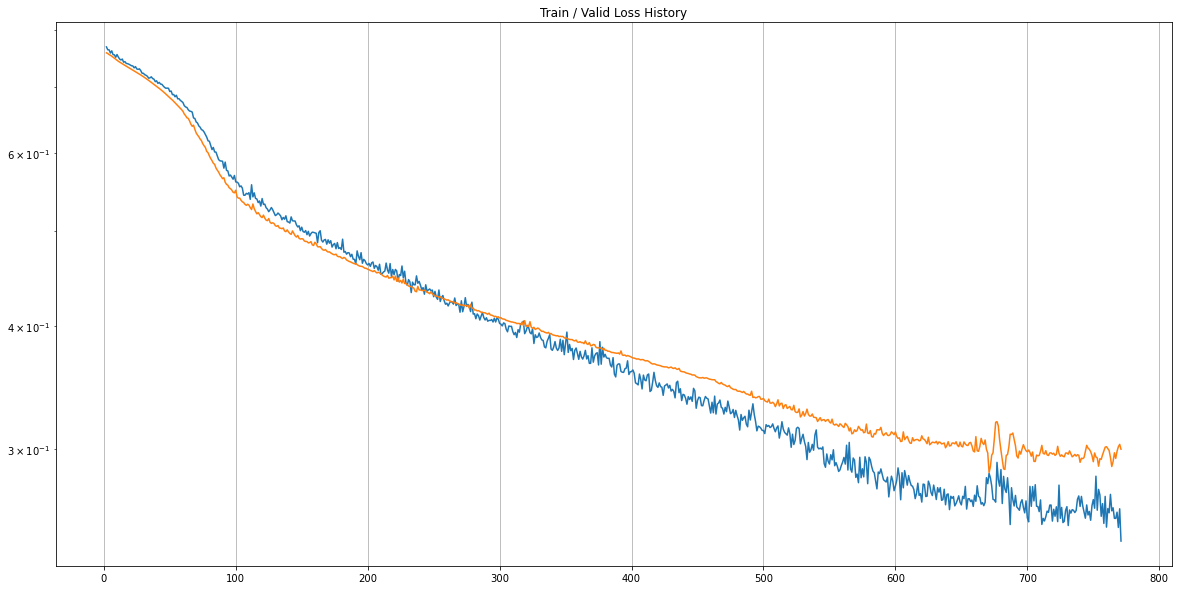

In [25]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [26]:
test_loss = 0
y_hat = []

with torch.no_grad():
    for x_i, y_i in test_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += loss
        y_hat.append(y_hat_i)
    test_loss = test_loss / len(test_loader)
    y_hat = torch.cat(y_hat, dim=0)

    answer_cnt = (y[2] == (y_hat>.5)).sum()
    total_cnt = len(y[2])

print(f'Test_loss : {test_loss:.4f} / Test_Accuracy : {answer_cnt / total_cnt :.4f}')


Test_loss : 0.3982 / Test_Accuracy : 0.8609


## AUC-ROC curve

### Reference
- https://velog.io/@sset2323/03-03.-%EC%A0%95%EB%B0%80%EB%8F%84%EC%99%80-%EC%9E%AC%ED%98%84%EC%9C%A8
- https://sumniya.tistory.com/26

- ROC curve : binary classification(이진분류)의 성능을 측정하는 기준, 도구
- X축이 FPR(실제로는 음성인데, 양성으로 잘못 분류), Y축이 TPR(실제로는 양성인데 음성으로 잘못분류) - trade off의 성격을 가짐
- 정밀도(Precision) : 모델이 양성으로 분류한 것 중 실제로 양성인것의 비율(참인에 참으로 맞출 확률) -> TP/TP+FP
- 재현율(Recall) : 실제 양성인것중 모델이 양성으로 예측한것의 비율(참으로 예측했는데 참일 확률) -> TP/TP+FN

위 정밀도와 재현율의 문제점은, 참일 경우만을 표본으로 삼았기에, 거짓을 거짓으로 맞춘것을 맞춘것으로 보지 않고있다. 이 부분을 고려할 수 있는것이 '정확도'임

- 정확도(Accuracy) : 참이든 거짓이든 정답과 비교하여 맞춘비율(문제점 : 데이터가 불균형하여, 참이나 거짓으로 쏠려있을 경우 높게 나오는 문제)
- F1 Score : 정확도

In [27]:
yy = [1 if i>.5 else 0 for i in y_hat_i]

In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, accuracy_score, confusion_matrix, precision_score, recall_score


In [29]:
# trade off 관계인 정밀도와 재현율을 적절한 위치에서 조절하기 위해서는 아무래도 sigmoid(혹은 ReLU등)와 같은 
# 활성함수를 통과한 확률값을 참으로 인식하는 threshold를 조절하여 셋팅할 수 있을듯.

print(f'1)Accuracy(정확도) : {accuracy_score(y[2] , yy):.4f}')
print(f'2)Precision(정밀도) : {precision_score(y[2], yy):.4f}')
print(f'3)Recall(재현율) : {recall_score(y[2], yy):.4f}')
print("=="*20)
confusion = confusion_matrix(y[2], yy)

tn = confusion[0][0]
fn = confusion[1][0]
fp = confusion[0][1]
tp = confusion[1][1]

print(f'1.TN(양성을 음성으로) {tn}/{len(y[2])}건 ({tn/len(y[2]):.4f})') 
print(f'2.FN(음성을 양성으로) {fn}/{len(y[2])}건 ({fn/len(y[2]):.4f})') 
print(f'3.FP(음성을 음성으로) {fp}/{len(y[2])}건 ({fp/len(y[2]):.4f})')
print(f'4.TP(양성을 양성으로) {tp}/{len(y[2])}건 ({tp/len(y[2]):.4f})')

1)Accuracy(정확도) : 0.8609
2)Precision(정밀도) : 0.8488
3)Recall(재현율) : 0.9605
1.TN(양성을 음성으로) 26/115건 (0.2261)
2.FN(음성을 양성으로) 3/115건 (0.0261)
3.FP(음성을 음성으로) 13/115건 (0.1130)
4.TP(양성을 양성으로) 73/115건 (0.6348)


In [30]:
print(classification_report(y[2], yy))

              precision    recall  f1-score   support

         0.0       0.90      0.67      0.76        39
         1.0       0.85      0.96      0.90        76

    accuracy                           0.86       115
   macro avg       0.87      0.81      0.83       115
weighted avg       0.87      0.86      0.85       115



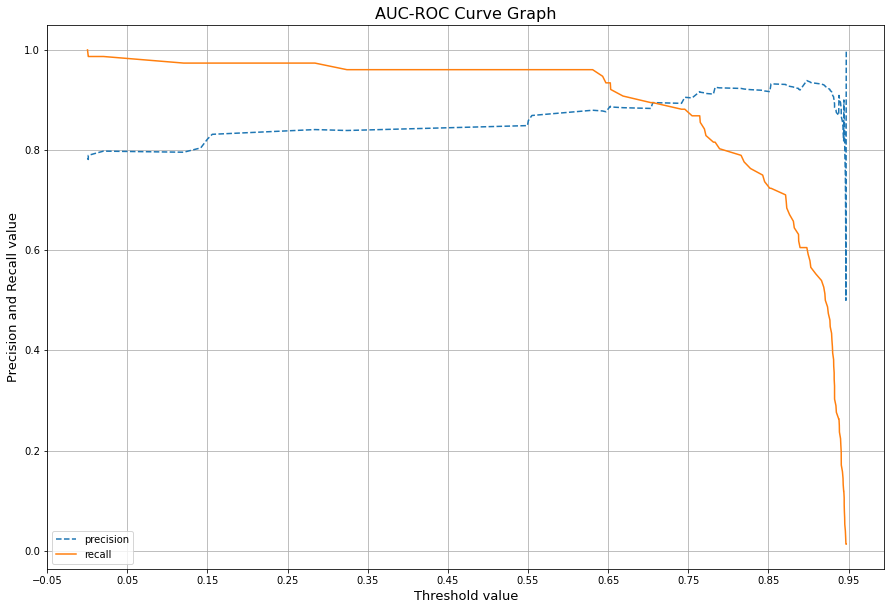

In [32]:
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
  
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(15,10))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
  
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
  
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.title('AUC-ROC Curve Graph', fontsize = 16)
    plt.xlabel('Threshold value', fontsize=13); plt.ylabel('Precision and Recall value', fontsize=13)
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y[2], y_hat)

- threshold 약 0.74정도에서 recall score와 precision score가 가장 높은(균형)형태를 이루므로 가장 적합한 threshold 수치라고 볼 수 있다.
- 다만 데이터 특성에 따라 recall 또는 precision중 중요한 부분에 초점을 맞추어 threshold를 설정할 수 있다.